# Calibrating the HBV model

## Setting up the python kernel

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

from rich import print
from tqdm import tqdm
from pathlib import Path
from ewatercycle_DA import DA
from datetime import datetime
from scipy.stats import qmc
from ipywidgets import IntProgress

## Loading in observed discharge data

In [2]:
# Loading in discharge data from Katima Mulilo
katima = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
          .drop(columns=['hh:mm'])
          .rename(columns={"YYYY-MM-DD": "Date", " Value": "Discharge [m^3/s]"}))

# Creating a dataframe with accessible dates and no invalid data 
katima['Date'] = pd.to_datetime(katima['Date'])
katima['Discharge [m^3/s]'] = katima['Discharge [m^3/s]'].replace(-999.000, np.nan)

# Defining the data period
start_calibration = '1986-01-01'
end_calibration = '2012-12-31'

# Reducing the dataframe to the calibration period
km = katima[(katima['Date'] >= start_calibration) & (katima['Date'] <= end_calibration)]

# Creating a dataframe of the flow data 
flow = pd.DataFrame(data=km['Discharge [m^3/s]'].values, index=km['Date'], columns=['Q'])

## Generating (or loading in) ERA5 forcings 

In [3]:
#Defining the location of the shape file to be used
km_shp = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG" /  "km_ERA5" / "km.shp"

#Defining the forcings directory
ERA5_folder = Path.home() / "ERA5"
ERA5_folder.mkdir(exist_ok=True)

# HBV model path 
HBV_model_path = Path.home() / "HBV_model"

# OPTION 1: Generating ERA5 forcings
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset="ERA5",
#    start_time= data_start,
#    end_time= data_end,
#    shape=km_shp,
#    directory=ERA5_folder)

# OPTION 2: Generating ERA5 forcings (For when ERA5 forcing has already been made before and exists in the directory)
load_location = ERA5_folder / "work" / "diagnostic" / "script" 
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [4]:
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='1986-01-01T00:00:00Z',
    end_time='2019-12-31T00:00:00Z',
    directory=PosixPath('/home/zoe/ERA5/work/diagnostic/script'),
    shape=PosixPath('/home/zoe/ERA5/work/diagnostic/script/km.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_1986-2019.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_1986-2019.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1986-2019.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

In [5]:
ds_ERA5 = xr.open_mfdataset([ERA5_forcing['pr'],ERA5_forcing['evspsblpot'],ERA5_forcing['rsds']])

#Setting max/min values in order to remove outliers 
rsds_max = 375  # W/m²
rsds_min = 0

evap_max = 0.00008  # kg/m²/s
evap_min = 0

pr_max = 0.00040  # kg/m²/s
pr_min = 0

# Replace outliers with NaN
ds_ERA5['rsds'] = ds_ERA5['rsds'].where((ds_ERA5['rsds'] >= rsds_min) & (ds_ERA5['rsds'] <= rsds_max))
ds_ERA5['evspsblpot'] = ds_ERA5['evspsblpot'].where((ds_ERA5['evspsblpot'] >= evap_min) & (ds_ERA5['evspsblpot'] <= evap_max))
ds_ERA5['pr'] = ds_ERA5['pr'].where((ds_ERA5['pr'] >= evap_min) & (ds_ERA5['pr'] <= evap_max))

# Interpolate over NaNs (time interpolation)
ds_ERA5['rsds'] = ds_ERA5['rsds'].interpolate_na(dim='time', method='linear', fill_value="extrapolate")
ds_ERA5['evspsblpot'] = ds_ERA5['evspsblpot'].interpolate_na(dim='time', method='linear', fill_value="extrapolate")
ds_ERA5['pr'] = ds_ERA5['pr'].interpolate_na(dim='time', method='linear', fill_value="extrapolate")

ds_ERA5.to_netcdf("ERA5_forcing_cleaned.nc")

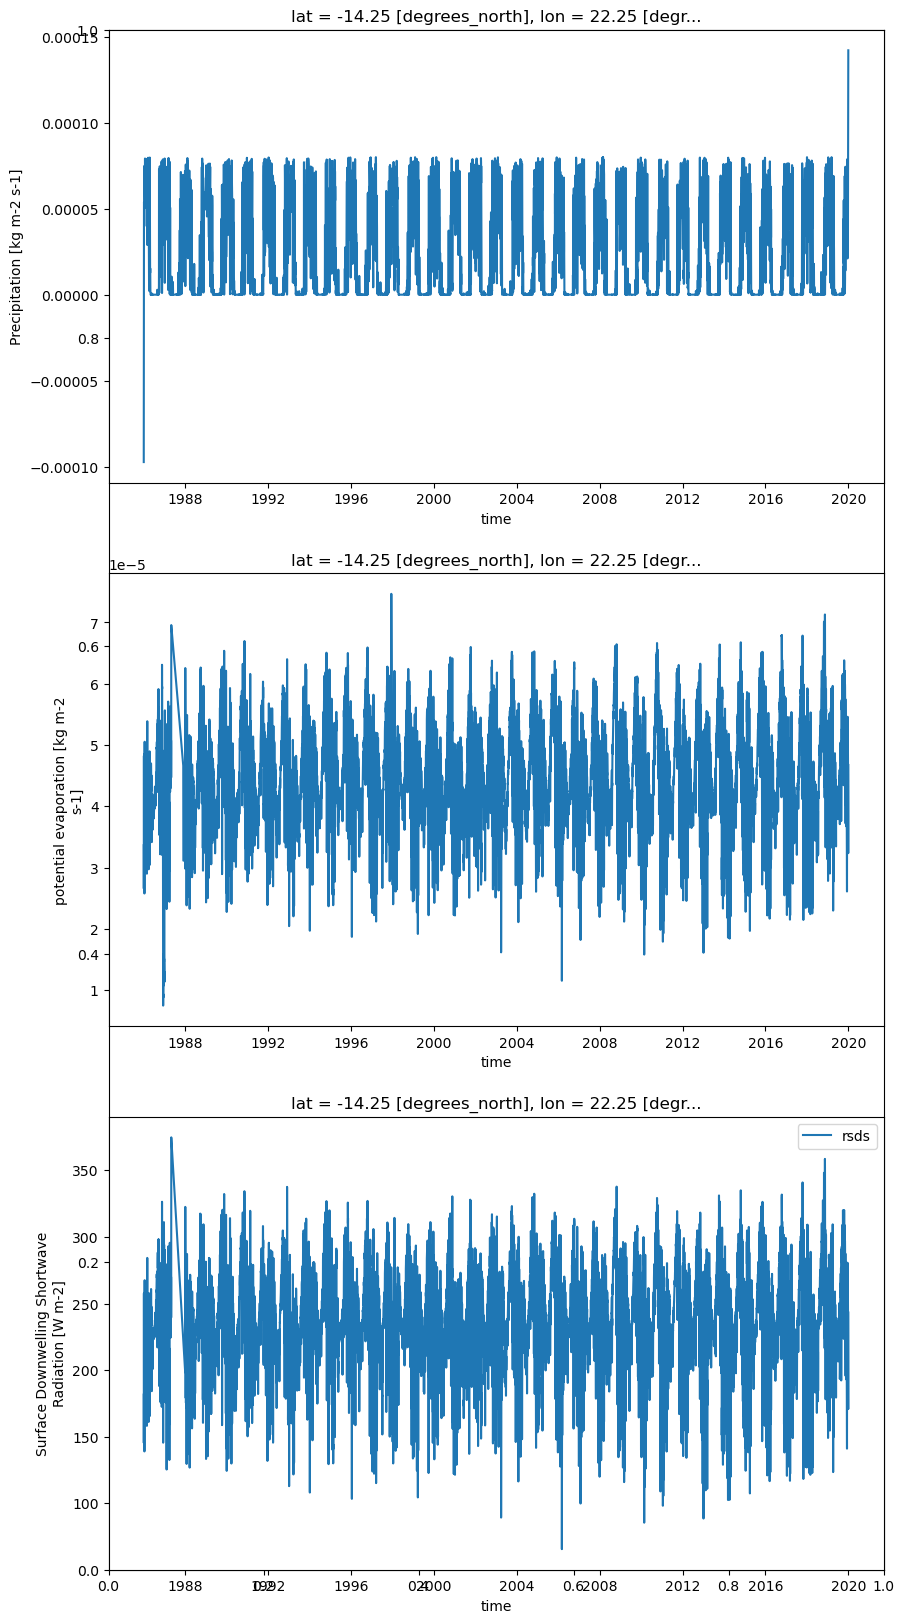

In [6]:
# Quick plot of the ERA5 data

plt.subplots(figsize=(10,20))
plt.subplot(3,1,1)
ds_ERA5["pr"].plot(label = 'precipitation')
plt.subplot(3,1,2)
ds_ERA5["evspsblpot"].plot(label = 'potential evaporation')
plt.subplot(3,1,3)
ds_ERA5["rsds"].plot(label = 'rsds')
plt.legend()


## Defining functions to determine the model of best fit

### 1. Root Mean Square Error

In [7]:
def RMSE(output, observed, start, end):
     # Making sure the given dates are in the correct format
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    
    # Making sure the date of the modelled output and onserved input are in the correct format
    output.index = pd.to_datetime(output.index)
    observed.index = pd.to_datetime(observed.index)

    # Combine the model output and the observation into one data frame 
    hydro_data = pd.concat([output.reindex(observed.index, method='ffill'), observed], axis=1, keys=['model', 'observation'])
    hydro_data = hydro_data.dropna()
    
    # Making sure to only take the calibration period
    hydro_data = hydro_data[(hydro_data.index > start) & (hydro_data.index < end)]
    
    # Calculate the absolute square difference
    squarediff = (hydro_data['model'] - hydro_data['observation']) ** 2
    rootMeanSquareDiff = np.sqrt(np.mean(squarediff))
    
    return rootMeanSquareDiff


### 2. Kling Gupta Efficiency

In [8]:
def KGE(output, observed, start, end):
    # Normalize datetime indices
    output.index = pd.to_datetime(output.index).normalize()
    observed.index = pd.to_datetime(observed.index).normalize()

    # Normalize start and end dates
    start = pd.to_datetime(start).normalize()
    end = pd.to_datetime(end).normalize()

    # Subset time range
    output = output[(output.index >= start) & (output.index <= end)]
    observed = observed[(observed.index >= start) & (observed.index <= end)]

    # Combine and align
    hydro_data = pd.concat([output, observed], axis=1)
    hydro_data.columns = ['output', 'observed']
    hydro_data = hydro_data.dropna()

    if len(hydro_data) == 0:
        return np.nan  # avoid error

    # Compute KGE components
    r = np.corrcoef(hydro_data['observed'], hydro_data['output'])[0, 1]
    alpha = np.mean(hydro_data['output']) / np.mean(hydro_data['observed'])
    beta = (np.std(hydro_data['output']) / np.mean(hydro_data['output'])) / (np.std(hydro_data['observed']) / np.mean(hydro_data['observed']))

    kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    return kge


## Calibrating to find the parameters of best fit

### Setting the parameters

In [9]:
# Set the number of HBV model ensembles you will test against the observed discharge
N = 2000

In [10]:
# Define the initial state parameters (Si,  Su, Sf, Ss, Sp)
s_0 = np.array([0,  100,  0,  5,  0])

# Define parameters and their corresponding boundary values 
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
param_mins = np.array([0, 0.2, 40, 0.5, 0.001, 1, 0.01, 0.0001, 0.01])
param_maxs = np.array([8, 1, 800, 4, 0.3, 10, 0.1, 0.01, 1])

#Fill the parameters array with N random values between each minimum and maximum 
sampler = qmc.LatinHypercube(d=len(param_names))
sample = sampler.random(n=N)
parameters = qmc.scale(sample, param_mins, param_maxs)

In [11]:
# Observe the randomly chosen variables for each parameter to confirm their boundaries are adhered to
print(list(zip(param_names, np.round(parameters[0], decimals=3))))

[
    ('Imax', 7.87),
    ('Ce', 0.522),
    ('Sumax', 49.791),
    ('Beta', 1.445),
    ('Pmax', 0.253),
    ('Tlag', 5.983),
    ('Kf', 0.083),
    ('Ks', 0.009),
    ('FM', 0.428)
]

In [12]:
# The HBV model returns values in mm/day so in order to compare this to the observed data it must b converted to m^3/s
catchment_area_km2 = 334882.8

def mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

### 1. Running the model with the RMSE line fit

In [13]:
# ensemble = []

# for counter in range(N): 
#     ensemble.append(ewatercycle.models.HBVLocal(forcing=ERA5_forcing))
#     config_file, _ = ensemble[counter].setup(parameters = parameters[counter],  initial_storage=s_0, cfg_dir = HBV_model_path)
#     ensemble[counter].initialize(config_file)

In [14]:
# # Using a progress bar gives an indication of how long the process will take. This is particularly useful when N is chosen as a large number.
# f = IntProgress(min=0, max=N)
# display(f)

# # Array to store level of fit values
# objectives_RMSE = []

# # Loop over ensemble members
# for ensembleMember in ensemble:
#     Q_m_RMSE = []
#     time_RMSE = []
#     while ensembleMember.time < ensembleMember.end_time:
#         ensembleMember.update()
#         discharge_this_timestep = ensembleMember.get_value("Q")
#         Q_m.append(discharge_this_timestep[0])
#         time.append(ensembleMember.time_as_datetime)

#     # Create DataFrame for model results
#     Q_m = mmday_to_m3s(np.array(Q_m), catchment_area_km2)
#     discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
    
#     # Calculate the model of best-fit function
#     fit_RMSE = RMSE(discharge_dataframe['model output'], flow['Q'], start_calibration, end_calibration)
#     objectives_RMSE.append(fit_RMSE)

#     # Free up memory
#     del Q_m, time, discharge_dataframe, fit_RMSE
#     f.value += 1

# # Clean up models to save memory
# for ensembleMember in ensemble:
#     ensembleMember.finalize()

In [15]:
# # Showing which parameter set is the best fit with the RMSE function
# parameters_RMSE_index = np.argmin(np.array(objectives_RMSE))
# if np.min(np.array(objectives_RMSE)) == np.inf:
#     print("No real parameter is chosen")

# parameters_RMSE = parameters[parameters_RMSE_index]

# print(f'The best RMSE parameters are: {list(zip(param_names, np.round(parameters_RMSE, decimals=3)))}')

### 2. Running the model with the KGE line fit

In [16]:
ensemble = []

for counter in range(N): 
    ensemble.append(ewatercycle.models.HBVLocal(forcing=ERA5_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters = parameters[counter],
                            initial_storage=s_0,
        cfg_dir = HBV_model_path)
    ensemble[counter].initialize(config_file)

In [17]:
# Using a progress bar gives an indication of how long the process will take. This is particularly useful when N is chosen as a large number.
f = IntProgress(min=0, max=N)
display(f)

# Array to store level of fit values
objectives_KGE = []

# Loop over ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(ensembleMember.time_as_datetime)

    # Create DataFrame for model results
    Q_m = mmday_to_m3s(np.array(Q_m), catchment_area_km2)
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
    
    # Calculate the model of best-fit function
    fit_KGE = KGE(discharge_dataframe['model output'], flow['Q'], start_calibration, end_calibration)
    objectives_KGE.append(fit_KGE)

    # Free up memory
    del Q_m, time, discharge_dataframe, fit_KGE
    f.value += 1

# Clean up models to save memory
for ensembleMember in ensemble:
    ensembleMember.finalize()

IntProgress(value=0, max=2000)

In [18]:
# Showing which parameter set is the best fit
parameters_KGE_index = np.argmax(np.array(objectives_KGE))
if np.min(np.array(objectives_KGE)) == np.inf:
    print("No real parameter is chosen")

parameters_KGE = parameters[parameters_KGE_index]

print(f'The best KGE parameters are: {list(zip(param_names, np.round(parameters_KGE, decimals=3)))}')


The best KGE parameters are: [('Imax', 2.387), ('Ce', 0.23), ('Sumax', 787.343), ('Beta', 2.935), ('Pmax', 0.056), 
('Tlag', 1.132), ('Kf', 0.013), ('Ks', 0.004), ('FM', 0.086)]

In [19]:
np.set_printoptions(suppress=True)

# print(f'The RMSE paramters are: {parameters_RMSE}')

print(f'The KGE paramters are: {parameters_KGE}')


The KGE paramters are: [  2.38699337   0.22964513 787.34268344   2.93539848   0.05634423
   1.1315796    0.01348767   0.00448292   0.08633531]